# Fast Gradient Sign Method

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import models
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 10.0)
from IPython.display import clear_output


# Import helper functions
from modules.helper import *
from modules.dataset import ImageNetSubset
from modules.fgsm import apply_fgsm
from modules.fgsm import compute_all_fgsm

## 1. Load Model and Data

We load the pre-trained googleNet and the data. For details see notebook `00_Helper-Functions`.

In [2]:
# Load model and data
model = models.googlenet(pretrained=True)
model.eval();

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]   

preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

data_loader = torch.utils.data.DataLoader(
    ImageNetSubset("data/ImageNet_subset//dev_dataset.csv", "data/ImageNet_subset//images/", transform=preprocess))

## 2. Attack


This method by [1] generates adversarial examples quickly. It computes a step of gradient descent and moves one step of magnitude $\epsilon$ into the direction of this gradient:

\begin{equation}
\tag{1.1}
\widetilde{x} = x + \eta
\end{equation}

\begin{equation}
\tag{1.2}
\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))
\end{equation}

Since we scale the data to a range of [0, 1] first and then standardize, we have to standardize epsilon as well.

In [4]:
def compare_examples_fgsm(epsilon, idx, folder=None):
    '''
    Generates an example using FGSM and summarizes the attack.
    
    Inputs:
    epsilon -- Hyperparameter for FGSM
    idx     -- Index of sample   
    folder  -- If given image will be saved to this folder
    '''

    # Get data
    image_clean, target_class = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    target_class.unsqueeze_(0)

    # Predict clean example
    labels, confidences, gradient = predict(model, image_clean, target_class, return_grad=True)
    label_clean = labels[0]
    conf_clean = confidences[0]
    
    # Compute adversarial image and predict for it.
    image_adv = apply_fgsm(image_clean, mean, std, epsilon, gradient)    
    labels, confidences, _ = predict(model, image_adv, target_class, return_grad=False)
    label_adv = labels[0]
    conf_adv = confidences[0]
    
    # Plot
    summarize_attack(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, target_class, idx,
                        folder=folder)

In [6]:
def get_attack_series(epsilons, sample, save=False):
    '''
    Generates four adversaries with the specified epsilons and displays them along with the clean image.
    
    Inputs:
    epsilons -- List of four attack strengths
    sample   -- Number of the sample to use for attacks
    save     -- Saves image series to folder FGSM is True

    Returns:
    output   -- Generated image series
    '''
      
    assert(len(epsilons) == 4)
    
    image_clean, target_class = data_loader.dataset[sample]
    image_clean.unsqueeze_(0)
    target_class.unsqueeze_(0)

    # Predict clean example
    predicted_classes, confidences, gradient = predict(model, image_clean, target_class, return_grad=True)
    
    # Compute adversarial image and predict for it.
    image_0 = show_tensor_image(image_clean)
    image_1 = show_tensor_image(apply_fgsm(image_clean, mean, std, epsilons[0], gradient))
    image_2 = show_tensor_image(apply_fgsm(image_clean, mean, std, epsilons[1], gradient))
    image_3 = show_tensor_image(apply_fgsm(image_clean, mean, std, epsilons[2], gradient))
    image_4 = show_tensor_image(apply_fgsm(image_clean, mean, std, epsilons[3], gradient))

    # Put images side-by-side
    images = [image_0, image_1, image_2, image_3, image_4]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)
    output = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    
    for im in images:
      output.paste(im, (x_offset,0))
      x_offset += im.size[0]

    if save is True:
        output.save("plots/FGSM/Sample_" + str(sample) + "_series.png")
    
    return output

## 0. Introduction

			Clean image	 Adversarial image

Actual class: 		barrel, cask			barrel, cask
Predicted class: 	barrel, cask			barrel, cask
Confidence: 		99.99%				14.81%



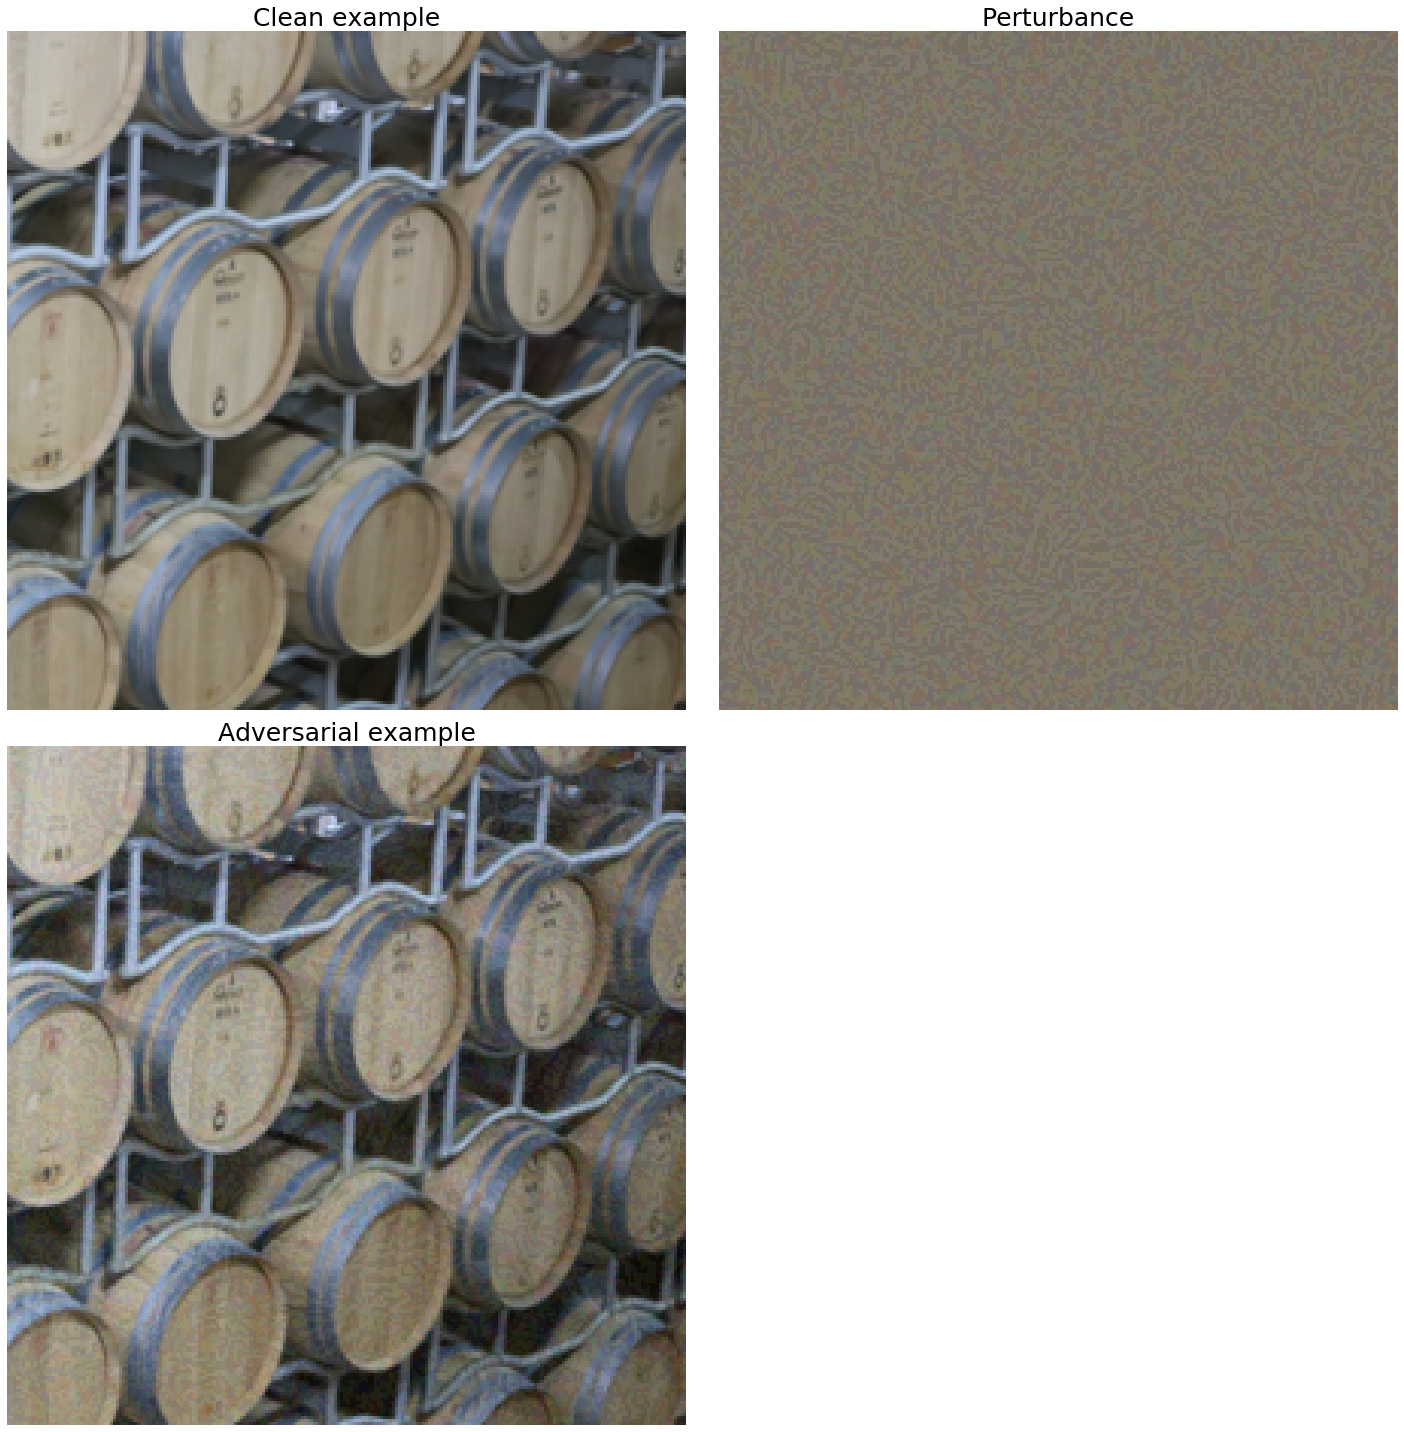

In [7]:
# Example with highest confidence
epsilon = 6/255
idx = 766

compare_examples_fgsm(epsilon, idx, folder="FGSM")

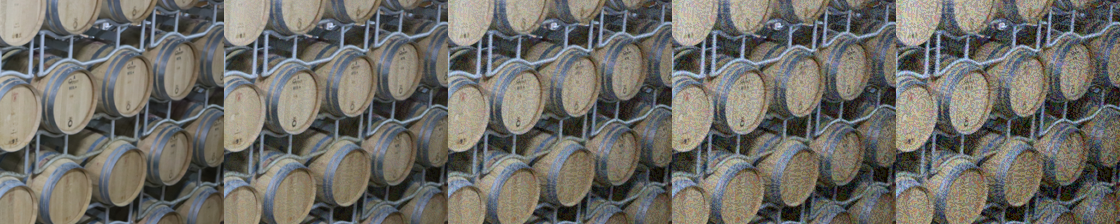

In [37]:
# Series of adversaries
samle = 766
epsilons = [4/255, 8/255, 12/255, 16/255]

images = get_attack_series(epsilons, sample)
images

## 1. All Images

We are splitting the data according to the original confidences. For each of the intervals we craft adversarial examples at varying epsilon and report the confidence and accuracy of these attacks for the interval.


### 1.1 Intervals of initial confidences

In [6]:
def confidence_interval(min_confidence, max_confidence):
    '''
    Splits predictions on clean dataset into provided interval of confidences. Then crafts adversarial examples
    from it for correct initital predictions and fixed epsilons and returns confidences, top1 and top5
    for those.
    
    Inputs:
    min_confidence -- Minimum confidence to consider
    max_confidence -- Maximum confidence to consider
    
    Returns:
    result         -- Dataframe with top1, top5 and confidence for prediction
    '''
    
    # Set perturbation
    epsilons = [0, 0.1/255, 0.2/255, 0.3/255, 0.4/255, 0.5/255, 0.7/255, 1/255, 2/255,
                4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255]

    # Take list results
    result = pd.read_csv("results/Clean-Predictions.csv", index_col=0)

    # Filter correct predictions
    samples = result.loc[result["Accuracy Top 1"] == 1]

    # Filter confidence
    samples = samples.loc[samples["Confidence"] > min_confidence]
    samples = samples.loc[samples["Confidence"] <= max_confidence]

    # Get samples
    samples = list(samples["Sample"])

    # Predict
    accurcy_top1 = []
    accurcy_top5 = []
    confidence_adversarial = []

    for epsilon in epsilons: 
        acc_sub_adver_top1 = []
        acc_sub_adver_top5 = []
        conf_sub_adver = []    
        i = 1

        for sample in samples:
            image_as_tensor, label = data_loader.dataset[sample]
            image_as_tensor.unsqueeze_(0)
            label.unsqueeze_(0)

            clear_output(wait=True)       
            print("Running for epsilon {:.2f}".format(epsilon*255))
            print("Sample: "+ str(i))
            print("Accuracy adversarial: {:.2f}".format(np.mean(acc_sub_adver_top1)))
            print("Confidence adversarial: {:.2f}".format(np.mean(conf_sub_adver)))

            # Predict with clean image
            gradient, corr, _, _, _ = predict(model, image_as_tensor, label, return_grad=True)

            # Generate adversarial example only if initial prediction was correct
            if corr == 1:            
                # Predict with adversarial image
                perturbed_data = apply_fgsm(image_as_tensor, epsilon, gradient)
                _, top1, top5, conf, _ = predict(model, perturbed_data, label)
                acc_sub_adver_top1.append(top1)
                acc_sub_adver_top5.append(top5)
                conf_sub_adver.append(conf)

            else:
                acc_sub_adver_top1.append(0)
                acc_sub_adver_top5.append(0)
                conf_sub_adver.append(0)

            i += 1

        # Add accuracies and confidences for clean and adversarial example
        accurcy_top1.append(np.mean(acc_sub_adver_top1))
        accurcy_top5.append(np.mean(acc_sub_adver_top5))
        confidence_adversarial.append(np.mean(conf_sub_adver))

    # Save results
    result = pd.DataFrame()
    epsilon = np.array(epsilons) * 255
    result["Epsilon_255"] = epsilon
    result["Accuracy Top 1"] = accurcy_top1
    result["Accuracy Top 5"] = accurcy_top5
    result["Confidence"] = confidence_adversarial
    result.to_csv("results/FGSM-Conf" + str(int(min_confidence*100)) + ".csv") 
    
    return result

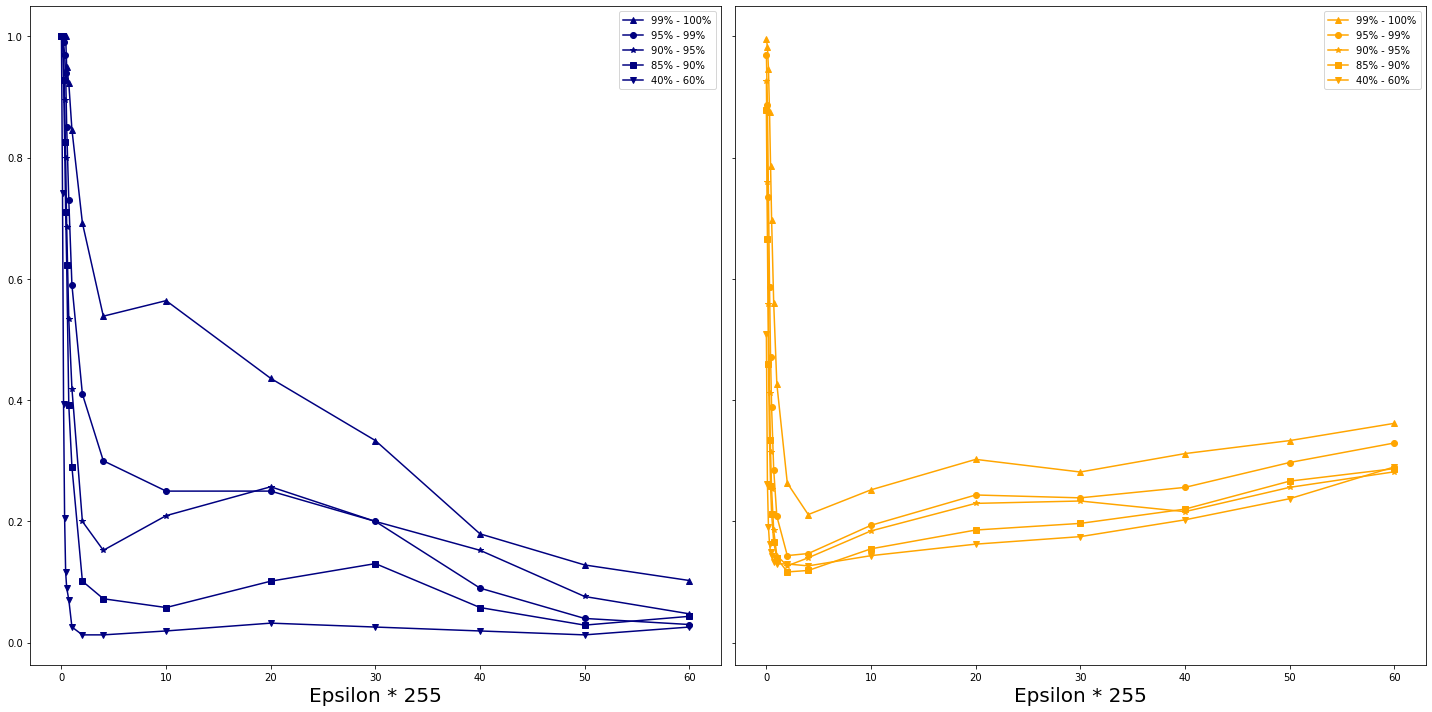

In [9]:
####### PLOT 3
# Load data
result_99 = pd.read_csv("results/FGSM-Conf99.csv")
result_95 = pd.read_csv("results/FGSM-Conf95.csv")
result_90 = pd.read_csv("results/FGSM-Conf90.csv")
result_85 = pd.read_csv("results/FGSM-Conf85.csv") 
result_40 = pd.read_csv("results/FGSM-Conf40.csv")

# Plot
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10))

## Top left: Accuracies
axs[0].plot(result_99["Epsilon_255"], result_99["Accuracy Top 1"], "-^", color='navy', label='99% - 100%')
axs[0].plot(result_95["Epsilon_255"], result_95["Accuracy Top 1"], "-o", color='navy', label='95% - 99%')
axs[0].plot(result_90["Epsilon_255"], result_90["Accuracy Top 1"], "-*", color='navy', label='90% - 95%')
axs[0].plot(result_85["Epsilon_255"], result_85["Accuracy Top 1"], "-s", color='navy', label='85% - 90%')
axs[0].plot(result_40["Epsilon_255"], result_40["Accuracy Top 1"], "-v", color='navy', label='40% - 60%')
axs[0].legend()
#axs[0].set_title("Accuracies", fontsize=25)
axs[0].set_xlabel("Epsilon * 255", fontsize=20)

## Bottom left: Confidences
axs[1].plot(result_99["Epsilon_255"], result_99["Confidence"], "-^", color='orange', label='99% - 100%')
axs[1].plot(result_95["Epsilon_255"], result_95["Confidence"], "-o", color='orange', label='95% - 99%')
axs[1].plot(result_90["Epsilon_255"], result_90["Confidence"], "-*", color='orange', label='90% - 95%')
axs[1].plot(result_85["Epsilon_255"], result_85["Confidence"], "-s", color='orange', label='85% - 90%')
axs[1].plot(result_40["Epsilon_255"], result_40["Confidence"], "-v", color='orange', label='40% - 60%')
axs[1].legend()
#axs[1].set_title("Confidences", fontsize=25)
axs[1].set_xlabel("Epsilon * 255", fontsize=20)

## Save plot
fig.tight_layout()
fig.savefig("plots/FGSM/Accuracies_Confidences.pdf")
fig.savefig("plots/FGSM/Accuracies_Confidences.png")

## 2. Individual Images

In [7]:
def get_confidence_acc_class(epsilon, idx):
    '''
    ...
    
    Inputs:
    epsilon -- Hyperparameter for FGSM
    idx     -- Index of sample   
    '''
    
    ## Get data
    image_clean, class_index = data_loader.dataset[idx]
    image_clean.unsqueeze_(0)
    class_index.unsqueeze_(0)

    ## Predict clean example
    _, _, gradient = predict(model, image_clean, class_index, return_grad=True)
              
    ## Compute adversarial image and predict for it.
    image_adv = apply_fgsm(image_clean, mean, std, epsilon, gradient)
    predicted_classes, confidences, _ = predict(model, image_adv, class_index, return_grad=False)
    
    
    if predicted_classes[0] == class_index.squeeze().numpy():
        acc2 = 1
    else: 
        acc2 = 0
        
    conf_adv = confidences[0]
    
    
    class_name_adversarial = idx_to_name(predicted_classes[0])
        
    return conf_adv, acc2, class_name_adversarial

In [8]:
def iterate_epsilons(idx):
    '''For a given sample number generates'''
    
    
    epsilons = [0, 0.1/255, 0.2/255, 0.3/255, 0.4/255, 0.5/255, 0.7/255, 1/255, 2/255, 3/255, 4/255, 5/255, 
                6/255, 8/255, 10/255, 12/255, 14/255, 16/255, 18/255, 20/255]

    conf_list = []
    acc_list = []

    print("Epsilon \t Accuracy \t Confidence \t Label")

    for epsilon in epsilons:
        conf_adv, acc, predicted_label = get_confidence_acc_class(epsilon, idx)
        conf_list.append(conf_adv)
        acc_list.append(acc)
        print(str(epsilon*255) + "\t\t\t" + str(acc) + "\t" + str(conf_adv) + "\t" + predicted_label)

    plt.plot(np.array(epsilons)*255, conf_list, "-^", color='orange', label='Confidence')
    plt.plot(np.array(epsilons)*255, acc_list, "s", color='navy', label='1: Corr, 0: False')
    plt.xlabel("Epsilon *255", fontsize=15)
    plt.legend()
    #plt.savefig("plots/FGSM/Confidence_Levels-Sample" + str(idx)+ ".pdf")
    #plt.savefig("plots/FGSM/png/Confidence_Levels-Sample" + str(idx)+ ".png")
    plt.show()

In [9]:
def analyze_fgsm_conf(sample, epsilon_conf, save_plot=False):
    '''
    Generates 4 plots: Image, conf over epsilon, top 5 conf for clean image, top 5 conf for adversarial image.
    
    '''  

    # Get data
    image_clean, class_index = data_loader.dataset[sample]
    image_clean.unsqueeze_(0)
    class_index.unsqueeze_(0)

    # Predict clean example
    _, confidences_clean, gradient = predict(model, image_clean, class_index, return_grad=True)
    
    epsilons = [0, 0.1/255, 0.2/255, 0.3/255, 0.4/255, 0.5/255, 0.7/255, 1/255, 2/255, 3/255, 4/255, 5/255, 
                6/255, 8/255, 10/255, 12/255, 14/255, 16/255, 18/255, 20/255]

    conf_list = []
    acc_list = []

    print("Epsilon \t Accuracy \t Confidence \t Label")

    for epsilon in epsilons:
        conf_adv, acc, predicted_label = get_confidence_acc_class(epsilon, sample)
        conf_list.append(conf_adv)
        acc_list.append(acc)
        print(str(epsilon*255) + "\t\t\t" + str(acc) + "\t" + str(conf_adv) + "\t" + predicted_label) 
    
    # Compute top 5 confidences for selected epsilon
    image_adv = apply_fgsm(image_clean, mean, std, epsilon_conf, gradient)  
    _, confidences_adv, _ = predict(model, image_adv, class_index, return_grad=False)
    
       
    # Plot
    samples = [1, 2, 3, 4, 5]
    
    fig, axs = plt.subplots(1, 4, figsize=(20,5))

    ## First image: Clean image
    im = show_tensor_image(image_clean)

    axs[0].imshow(im)
    axs[0].axis('off')

    ## Second image: Confidence dist over epsilon and correct/incorrect
    axs[1].plot(np.array(epsilons)*255, conf_list, "-^", color='orange', label='Confidence')
    axs[1].plot(np.array(epsilons)*255, acc_list, "s", color='navy', label='1: Corr, 0: False')
    axs[1].set_ylim(0, 1.1)
    axs[1].set_xlabel("Epsilon *255", fontsize=10)
    axs[1].legend()

    ## Third image: Clean image top 5 confidence
    axs[2].bar(samples, confidences_clean, color='orange')
    axs[2].set_ylim(0, 1.1)
    axs[2].set_xlabel("Epsilon *255", fontsize=10)

    ## Fourth image: Adversarial image selected epsilon top 5 confidence
    axs[3].bar(samples, confidences_adv, color='orange')
    axs[3].set_ylim(0, 1.1)
    axs[3].set_xlabel("Epsilon *255", fontsize=10)
    
    if save_plot is True:
        fig.tight_layout()
        fig.savefig("plots/FGSM/Individual_Images-Sample_" + str(sample) + ".png")

### 2.1 Confidence and correct/false class over epsilon for individual images
Can you find one which:
- Cannot be forced to change the class
- Changes class and then changes back?
- Has higher adversarial confidence than initial confidence

In [ ]:
# All images: Only for correct initial classifiation we compute adversaries.
epsilons = [1/255, 2/255, 4/255, 6/255, 8/255, 10/255]


result = pd.DataFrame()

for epsilon in epsilons:   
    conf = []
    
    for idx in range(1000):
        clear_output(wait=True)
        print("Epsilon " + str(epsilon*255))
        print(idx+1)
        conf_adv, acc, label_adv = get_confidence_acc_class(epsilon, idx)
        
        if acc == 1:
            conf.append(conf_adv)

        else:
            conf.append(0)

    result["Epsilon " + str(int(epsilon*255))] = conf

#result.to_csv("results/BIM-accuracies-corr_only.csv")

In [12]:
result = pd.read_csv("results/FGSM-accuracies-corr_only.csv", index_col=0)
result

,Epsilon 1,Epsilon 2,Epsilon 4,Epsilon 6,Epsilon 8,Epsilon 10
0,0.151650,0.084236,0.041904,0.040552,0.053289,0.084203
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.199058,0.085489,0.046457,0.045282,0.050924,0.062932
3,0.162078,0.149533,0.106008,0.138255,0.145719,0.123123
4,0.018643,0.028133,0.017726,0.019033,0.016589,0.020694
...,...,...,...,...,...,...
995,0.284941,0.437114,0.313043,0.156960,0.058075,0.050992
996,0.058664,0.081518,0.112703,0.108481,0.081313,0.058279
997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
998,0.033604,0.040841,0.059820,0.058273,0.063519,0.060053


#### 2.1.1 Predicted class invariant

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9984958	honeycomb
0.1			1	0.99721515	honeycomb
0.2			1	0.9936559	honeycomb
0.3			1	0.98548675	honeycomb
0.4			1	0.9702776	honeycomb
0.5			1	0.94641435	honeycomb
0.7			1	0.87577116	honeycomb
1.0			1	0.7662984	honeycomb
2.0			1	0.6421063	honeycomb
3.0			1	0.6387259	honeycomb
4.0			1	0.63160247	honeycomb
5.0			1	0.64614445	honeycomb
6.0			1	0.68201077	honeycomb
8.0			1	0.80579555	honeycomb
10.0			1	0.9198083	honeycomb
12.0			1	0.9653693	honeycomb
14.0			1	0.9822119	honeycomb
16.0			1	0.9883703	honeycomb
18.0			1	0.99088913	honeycomb
20.0			1	0.9928846	honeycomb


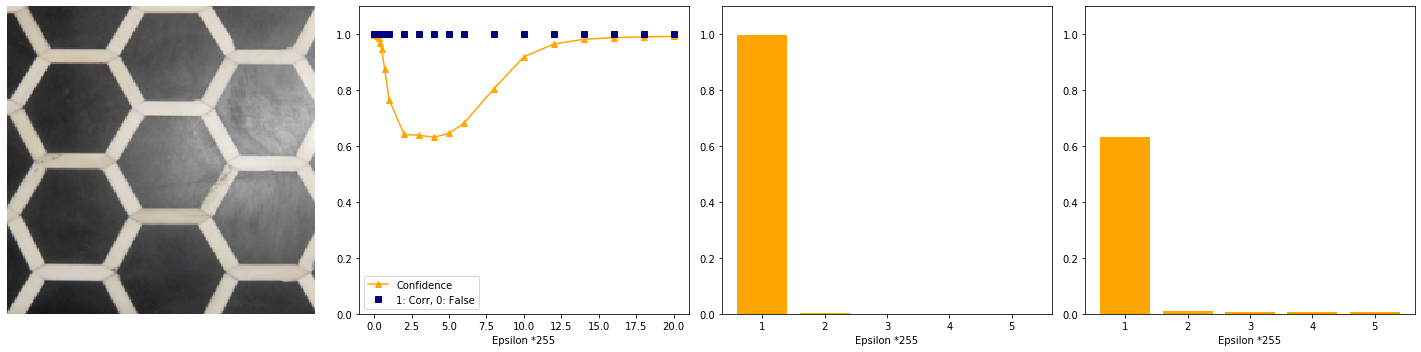

In [10]:
sample = 132
epsilon_conf = 4/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=True)

# Class doesn't change.
# Confidence incrreases again to almost initial level for higher epsilon. Why? How does it behave for other attack
# methods?

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.8916601	oystercatcher, oyster catcher
0.1			1	0.7187698	oystercatcher, oyster catcher
0.2			1	0.54159766	oystercatcher, oyster catcher
0.3			1	0.41286704	oystercatcher, oyster catcher
0.4			1	0.3320735	oystercatcher, oyster catcher
0.5			1	0.27710265	oystercatcher, oyster catcher
0.7			1	0.21350215	oystercatcher, oyster catcher
1.0			1	0.17391019	oystercatcher, oyster catcher
2.0			1	0.17523278	oystercatcher, oyster catcher
3.0			1	0.23270682	oystercatcher, oyster catcher
4.0			1	0.24771328	oystercatcher, oyster catcher
5.0			1	0.29038793	oystercatcher, oyster catcher
6.0			1	0.3768897	oystercatcher, oyster catcher
8.0			1	0.5554285	oystercatcher, oyster catcher
10.0			1	0.6141285	oystercatcher, oyster catcher
12.0			1	0.62475955	oystercatcher, oyster catcher
14.0			1	0.64022845	oystercatcher, oyster catcher
16.0			1	0.6605509	oystercatcher, oyster catcher
18.0			1	0.6375172	oystercatcher, oyster catcher
20.0			1	0.5848905	oystercatcher, 

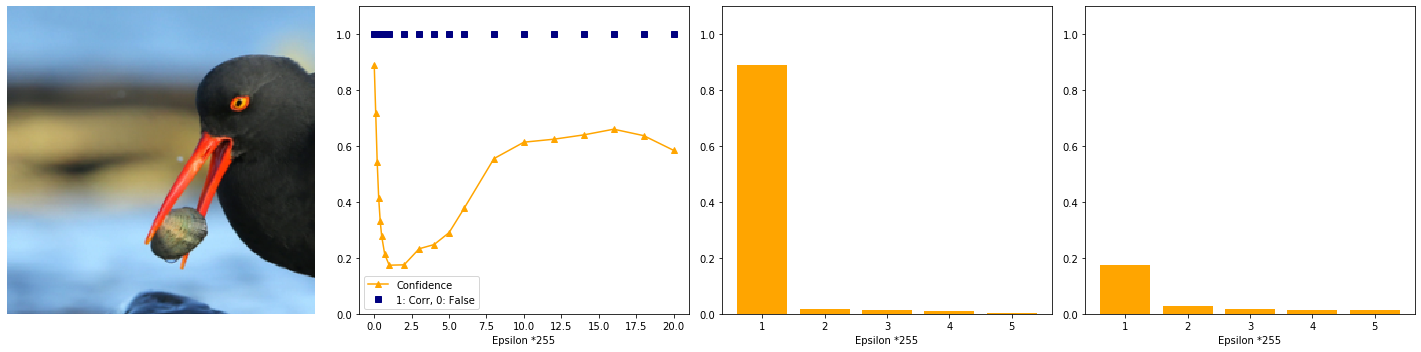

In [11]:
sample = 323
epsilon_conf = 2/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=True)

#### 2.1.2 Class bounces back

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			0	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			0	0.23515305	bottlecap
20.0			0	0.22546048	bottlecap


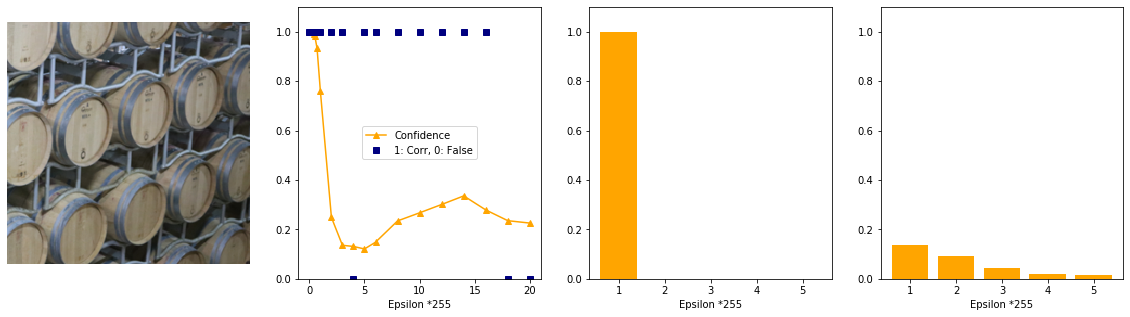

In [12]:
sample = 766
epsilon_conf = 3/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=False)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			0	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			0	0.23515305	bottlecap
20.0			0	0.22546048	bottlecap


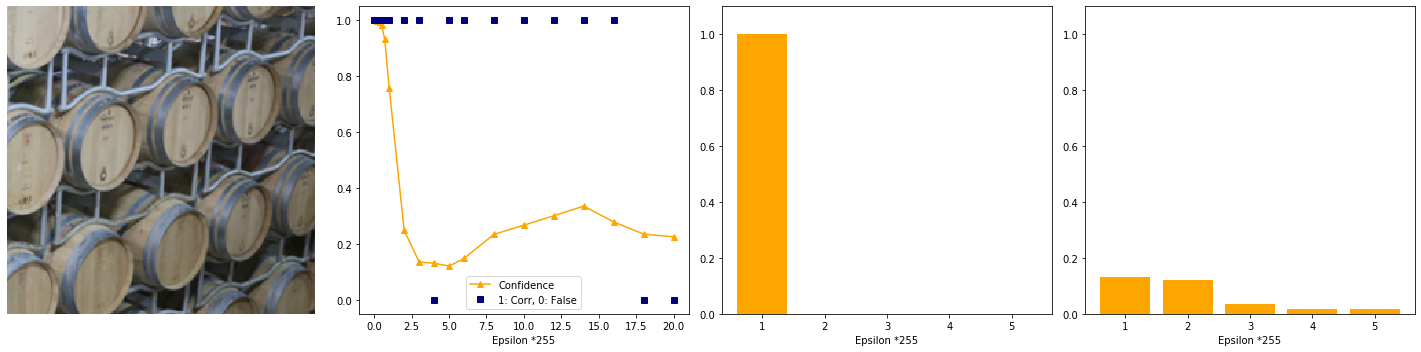

In [9]:
sample = 766
epsilon_conf = 4/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=True)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			0	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			0	0.23515305	bottlecap
20.0			0	0.22546048	bottlecap


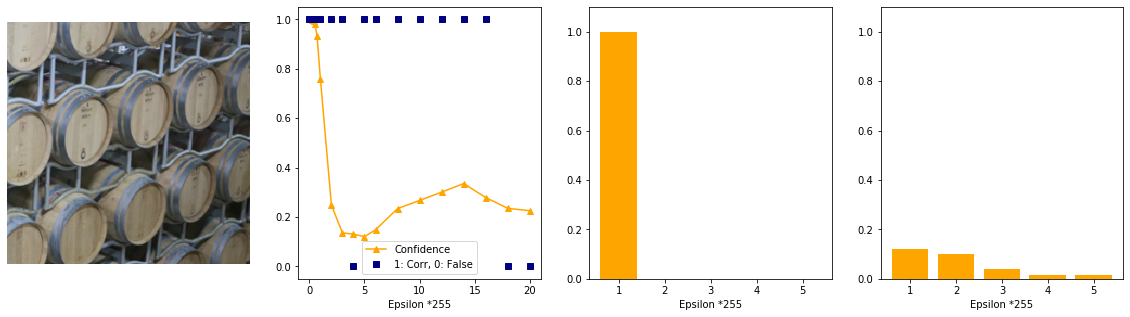

In [98]:
sample = 766
epsilon_conf = 5/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=False)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.9999355	barrel, cask
0.1			1	0.9997793	barrel, cask
0.2			1	0.9992168	barrel, cask
0.3			1	0.9974246	barrel, cask
0.4			1	0.992656	barrel, cask
0.5			1	0.9818143	barrel, cask
0.7			1	0.93215406	barrel, cask
1.0			1	0.75929576	barrel, cask
2.0			1	0.24853106	barrel, cask
3.0			1	0.1356677	barrel, cask
4.0			0	0.13086057	scale, weighing machine
5.0			1	0.12069081	barrel, cask
6.0			1	0.14814387	barrel, cask
8.0			1	0.23435521	barrel, cask
10.0			1	0.26709953	barrel, cask
12.0			1	0.3009068	barrel, cask
14.0			1	0.3354693	barrel, cask
16.0			1	0.27866164	barrel, cask
18.0			0	0.23515305	bottlecap
20.0			0	0.22546048	bottlecap


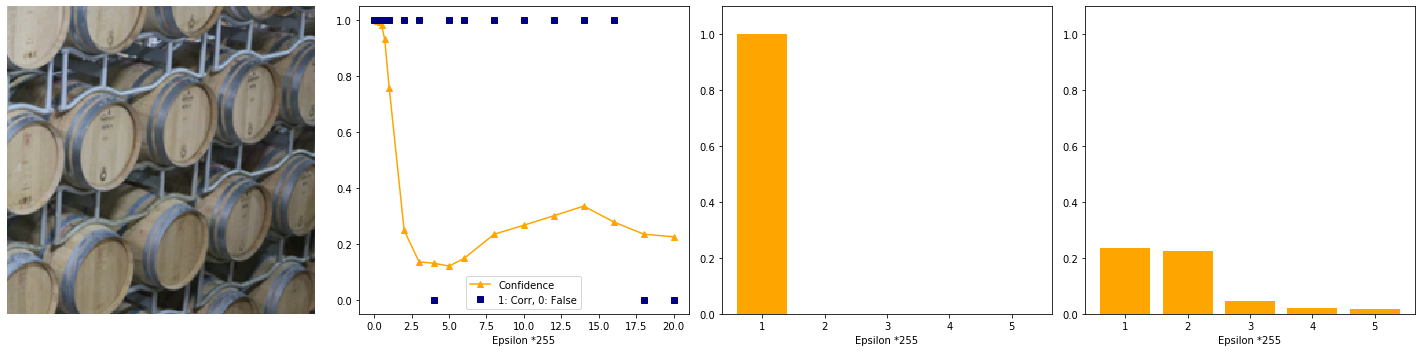

In [96]:
sample = 766
epsilon_conf = 18/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=False)

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.89812696	apron
0.1			1	0.655235	apron
0.2			1	0.40885675	apron
0.3			1	0.26146814	apron
0.4			1	0.18003756	apron
0.5			0	0.16804919	lab coat, laboratory coat
0.7			0	0.19214581	lab coat, laboratory coat
1.0			0	0.20965621	lab coat, laboratory coat
2.0			0	0.2010445	lab coat, laboratory coat
3.0			0	0.19409224	lab coat, laboratory coat
4.0			0	0.19547743	lab coat, laboratory coat
5.0			0	0.19839363	lab coat, laboratory coat
6.0			0	0.20357373	lab coat, laboratory coat
8.0			0	0.19334966	lab coat, laboratory coat
10.0			0	0.1673113	lab coat, laboratory coat
12.0			1	0.22230485	apron
14.0			1	0.31577015	apron
16.0			1	0.41265127	apron
18.0			1	0.5240265	apron
20.0			1	0.6241006	apron


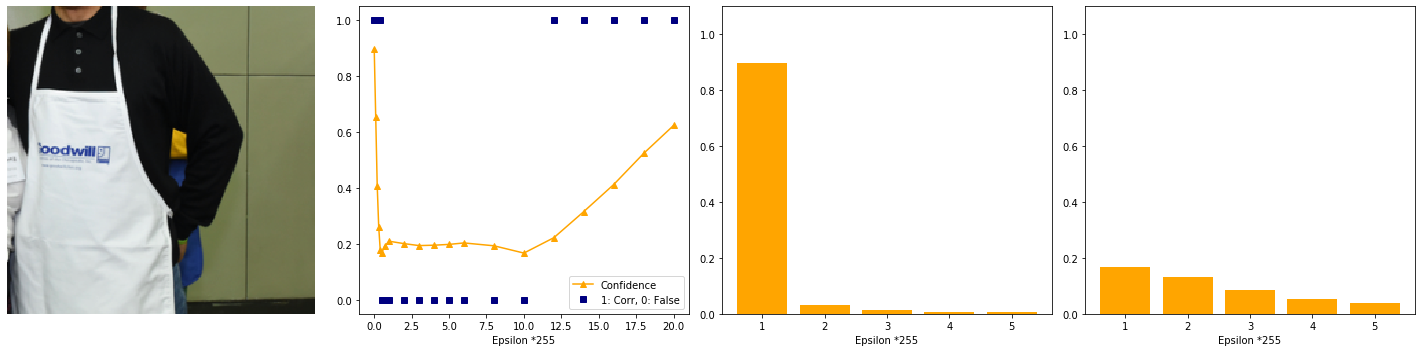

In [99]:
sample = 432
epsilon_conf = 0.5/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=True)

#### 2.1.3 Adversarial confidence greater than initial confidence

Epsilon 	 Accuracy 	 Confidence 	 Label
0			1	0.49230596	umbrella
0.1			0	0.61099654	lionfish
0.2			0	0.7307007	lionfish
0.3			0	0.7762353	lionfish
0.4			0	0.7989121	lionfish
0.5			0	0.80780685	lionfish
0.7			0	0.809179	lionfish
1.0			0	0.79589593	lionfish
2.0			0	0.76454836	lionfish
3.0			0	0.6705091	lionfish
4.0			0	0.5849818	lionfish
5.0			0	0.55822515	lionfish
6.0			0	0.5359005	lionfish
8.0			0	0.49316654	lionfish
10.0			0	0.5122343	lionfish
12.0			0	0.58115524	lionfish
14.0			0	0.63909125	lionfish
16.0			0	0.67584825	lionfish
18.0			0	0.68604165	lionfish
20.0			0	0.66359735	lionfish


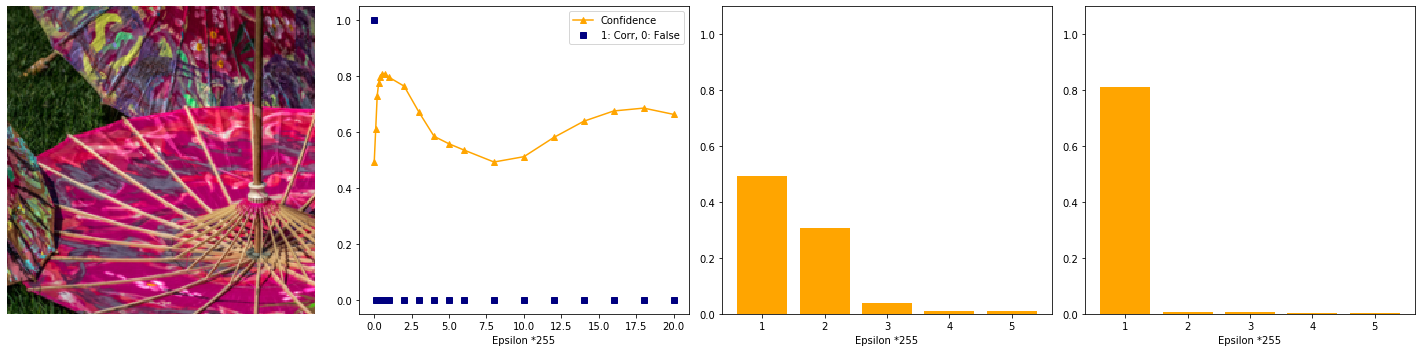

In [10]:
sample = 258
epsilon_conf = 0.57/255
analyze_fgsm_conf(sample, epsilon_conf, save_plot=True)

### 2.2 Confidence distribution for high and low initial confidence
-> Show plots confidence for top 5 for clean and adversarial example (It shouldn’t be flat)

### 2.2 All Images

We now run attacks with the whole dataset for different values of $\epsilon$. We will first, make predictions on clean images. Only if this prediction is correct we craft an adversarial example and attack the network. The networks accuracy on the clean dataset is $???$ as shown in the notebook `00_Helper-Functions`.

## 3. Discussion

In [4]:
epsilons = [0, 1/255, 2/255, 4/255, 8/255, 16/255, 32/255, 48/255, 64/255, 96/255, 128/255]
top1, top5, conf = compute_all_fgsm(model, data_loader, predict, mean, std, epsilons)

Running epsilon: 128.00
Sample: 999 of 1000


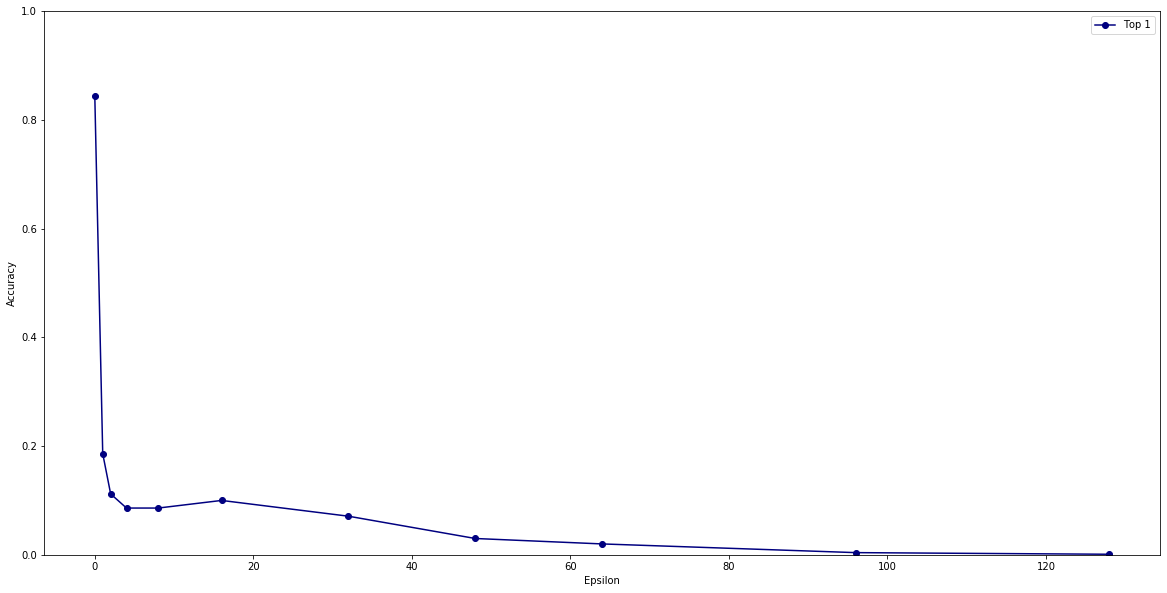

In [16]:
plt.plot(np.array(epsilons)*255, top1, "-o", color='navy', label='Top 1')
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

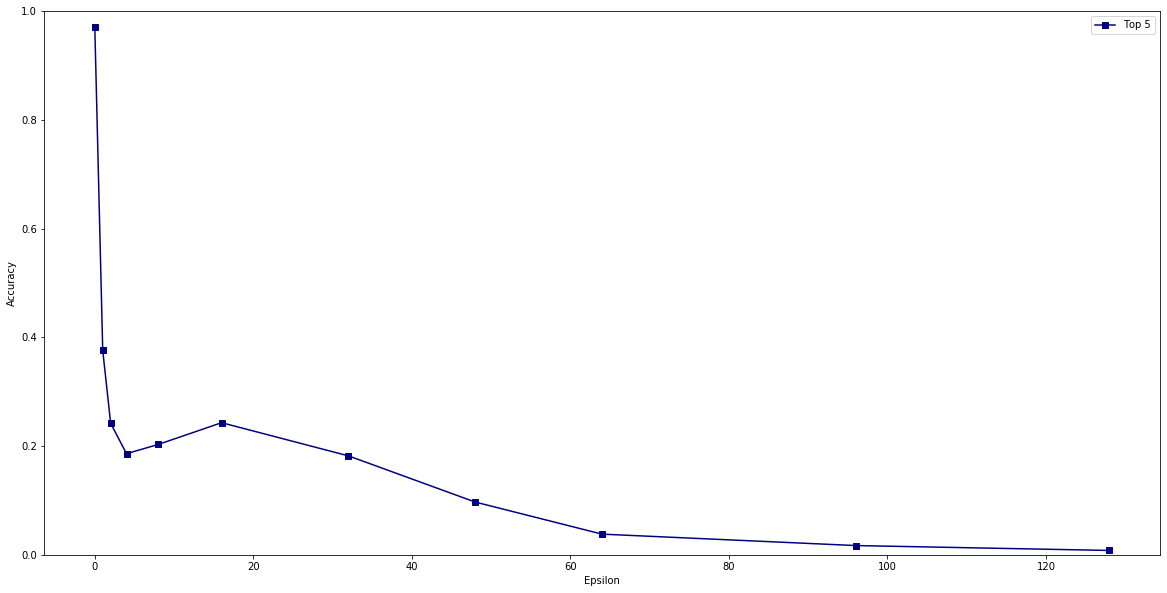

In [15]:
plt.plot(np.array(epsilons)*255, top5, "-s", color='navy', label='Top 5')
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

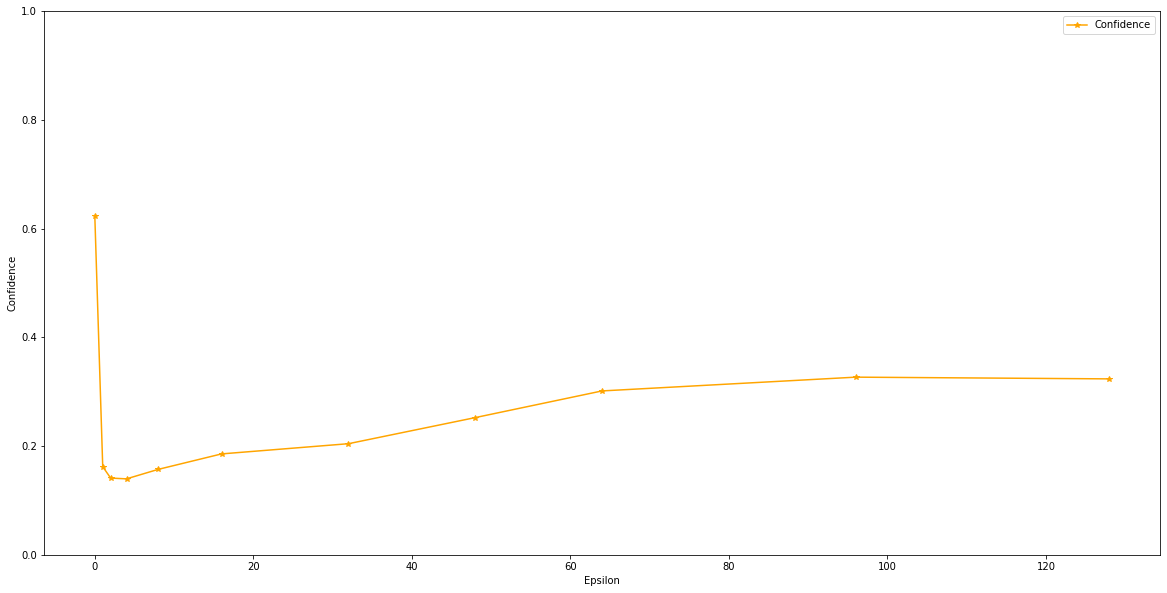

In [14]:
plt.plot(np.array(epsilons)*255, conf, "-*", color='orange', label='Confidence')
plt.ylim(0, 1)
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Confidence")
plt.show()

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*